# Simulations: How much data do you need for a decoding analysis?
##### Leyla Tarhan
##### ltarhan@g.harvard.edu
##### 4/2020

### This is a question that comes up a lot in fMRI world. Say you want to use decoding to detect whether there's a difference between two categories (e.g., big and small objects). How much data (e.g., runs or blocks or subjects) should you collect for each category?

### Here, I'm taking a simulation-based approach to ask two questions: 

### Q1: How much data do you need to detect a real difference between categories?
#### To address this, I'm simulate data with the following assumptions:
1. There is a real difference between the categories
2. The size of the difference depends upon the standard deviation and means specified, and is measured as a scaled euclidean distance. The default difference is XXXX.
3. I'm drawing data from 100 dimensions (in the fMRI case, each dimension is a voxel) and the data for each category is normally distributed (with some offset) in 100-dimensional space

Having simulated data that meet these assumptions, I'll iteratively draw a random sample from each category, and do 2-way classification to see if I can separate the categories. The size of the sample I draw will range from 10 to 100. The result will be a plot of the average classification accuracy (on held-out data) over samples of 10-100 data points. This can be interpreted as accuracy at detecting "true" positives (a real difference between categories).


### Q2. How much data do you need to avoid detecting a difference that isn't real?
#### Here, I'll take a similar approach with slightly different assumptions:
1. There is NOT a real difference between the categories
2. I'll draw data from a single 100-dimensionsal distribution.

Again, I'll iteratively draw a random sample from each "category," and do 2-way classification with sample sizes ranging from 10-100 points per category. This time, the result will be a plot of the average classifiction accuracy (which should be at chance, given that there's no real difference between these categories) for each sample size. This can be interpreted as the detection rate for false positives (an apparent difference when there is none).

In [ ]:
## to-do:
# [] check on how effect size is calculated (maybe distance between means != 1-d difference?)
# [] update covariance matrix so diagonal = standard deviation
# [] add in progress messages
# [] q2 (same as q1 but category means are the same)

In [1]:
## import libraries

# !pip install -U scikit-learn
# !pip install opencv-python

# data wrangling:
import numpy as np
import pandas as pd
import itertools
import statistics
import math
from copy import deepcopy as dc
from scipy.spatial import distance

# plotting:
import matplotlib.pyplot as plt
import seaborn as sns

# SVM:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2



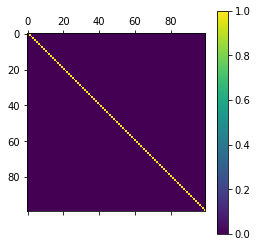

In [5]:
## General Setup
# variables for answering both questions

# data
nVox = 100 # number of voxels (or other dimensions)
sd = 1 # standard deviation of the distributions (keeping this the same for all distributions)
nIters = 100 # how many times you sample data of each size
nCats = 2 # how many categories you're classifying 

# training-testing split for classification analyses:
trainProp = .8 # 80% of data in each category used for training
testProp = .2 # 20% used for testing

# possible sample sizes
minN = 10
maxN = 100
nRange = range(minN, maxN+1)

# set up variance-covariance matrix for the multi-variate normal distributions:
covMat = np.identity(nVox)*sd**2 # orthogonal dimensions; main diagonal = s.d.^2 (variance)
# plot it to check:
plt.matshow(covMat);
plt.colorbar()
plt.show()


# seed a random number generator:
np.random.seed(444)

### Q1 - detecting a real difference

In [12]:
## setup for this section

# multi-variate means for the 2 categories' activation distributions:
popMeans_q1 = [1, 3]

# to estimate the size of this difference, calculate the euclidean distance 
# between the means and then scale that by the standard deviation of the distributions
# (intuitively: a larger standard deviation = closer distributions if you don't change the means)

def calcDist(meansVec):
    # numerator: euclidean distance between mean vectors:
    m1 = [meansVec[0] for d in range(nVox)]
    m2 = [meansVec[1] for d in range(nVox)]
    d = distance.euclidean(m1, m2)
    
    # denominator: variance of the distributions (which is set up to be the same for both distributions):
    var = sd**2
    
    return d/var

dist = calcDist(popMeans_q1)
print('Q1: estimated distance between groups = ' + str(dist))


Q1: estimated distance between groups = 20.0


In [13]:
## sample the data & classify the categories

# set up the multivariate means for each category:
cat1Means_q1 = np.full((nVox), popMeans_q1[0]) # length = # voxels (dimensions)
cat2Means_q1 = np.full((nVox), popMeans_q1[1]) 

# loop through the sample sizes
accuracyDict = {}
accuracyDictScram = {}

for n in nRange:
    
    currAccuracy = [] # set up an array to store classification accuracy for this sample size
    currAccuracyScram = [] # set up an array to store classification accuracy for scrambled data with this sample size
    
    # loop through the iterations for this sample size
    for i in range(nIters):

        # sample from both categories:
        cat1Patterns_q1 = np.random.multivariate_normal(cat1Means_q1, covMat, n) # category 1: sample size x voxels
        cat2Patterns_q1 = np.random.multivariate_normal(cat2Means_q1, covMat, n) # category 2: sample size x voxels

        # put the categories together:
        allCatsPatterns_q1 = np.concatenate((cat1Patterns_q1, cat2Patterns_q1)) # sample size * 2 categories x voxels

        # set up the labels for the classifier:
        labels = []
        for c, s in itertools.product(range(nCats), range(n)):
            labels.append(c)

        # make sure the data are in the expected size:
        assert len(labels) == allCatsPatterns_q1.shape[0], 'mismatch between labels length and patterns size'
        assert len(labels) == n*nCats, 'unexpected label length (should be sample size x categories)'
        assert allCatsPatterns_q1.shape[1] == nVox, 'unexpected patterns size (should be sample size*categories x voxels)'

        # partition the data into train / test subsets:
        (trainPatterns, testPatterns, trainLabels, testLabels) = train_test_split(allCatsPatterns_q1, labels, test_size = testProp, random_state=42)

        # train the classifier:
        model = LinearSVC(dual=False) # setting dual = false helps the algorithm converge faster
        model.fit(trainPatterns, trainLabels)

        # test the classifier:
        predictions = model.predict(testPatterns) # predicted labels for the held-out data

        # calculate accuracy (% of testing data that was correctly classified)
        comparisonVec = []
        comparisonVec = [predictions[e] == testLabels[e] for e in range(len(predictions))]
        comparisonVec = list(map(int, comparisonVec))
        currAccuracy.append(sum(comparisonVec)/len(comparisonVec))
        
        # --------------------------------------------------------------------
        # Scrambled baseline
        scramPatterns = dc(allCatsPatterns_q1)
        np.random.shuffle(scramPatterns) # shuffle the rows, keeping the labels intact
        (trainScramPatterns, testScramPatterns, trainScramLabels, testScramLabels) = train_test_split(scramPatterns, labels, test_size = testProp)
        modelScram = LinearSVC(dual=False) # set up the SVM
        modelScram.fit(trainScramPatterns, trainScramLabels) # train the SVM
        predictionsScram = model.predict(testScramPatterns) # test the SVM
        
        comparisonVecScram = []
        comparisonVecScram = [predictionsScram[e] == testScramLabels[e] for e in range(len(predictionsScram))]
        comparisonVecScram = list(map(int, comparisonVecScram))
        currAccuracyScram.append(sum(comparisonVecScram)/len(comparisonVecScram))


    # after looping through the iterations for this sample size, add the array to a dictionary
    # accuracyDict[str(n)] = currAccuracy
    # accuracyDictScram[str(n)] = currAccuracyScram
    accuracyDict[n] = currAccuracy
    accuracyDictScram[n] = currAccuracyScram
    assert len(currAccuracy) == nIters, 'accuracy isn''t being stored with expected length.'
    assert len(currAccuracyScram) == nIters, 'scrambled accuracy isn''t being stored with expected length.'

# after looping through all the sample sizes, result = a dictionary with classification accuracies across iterations for every sample size.


C:\Users\Leyla\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


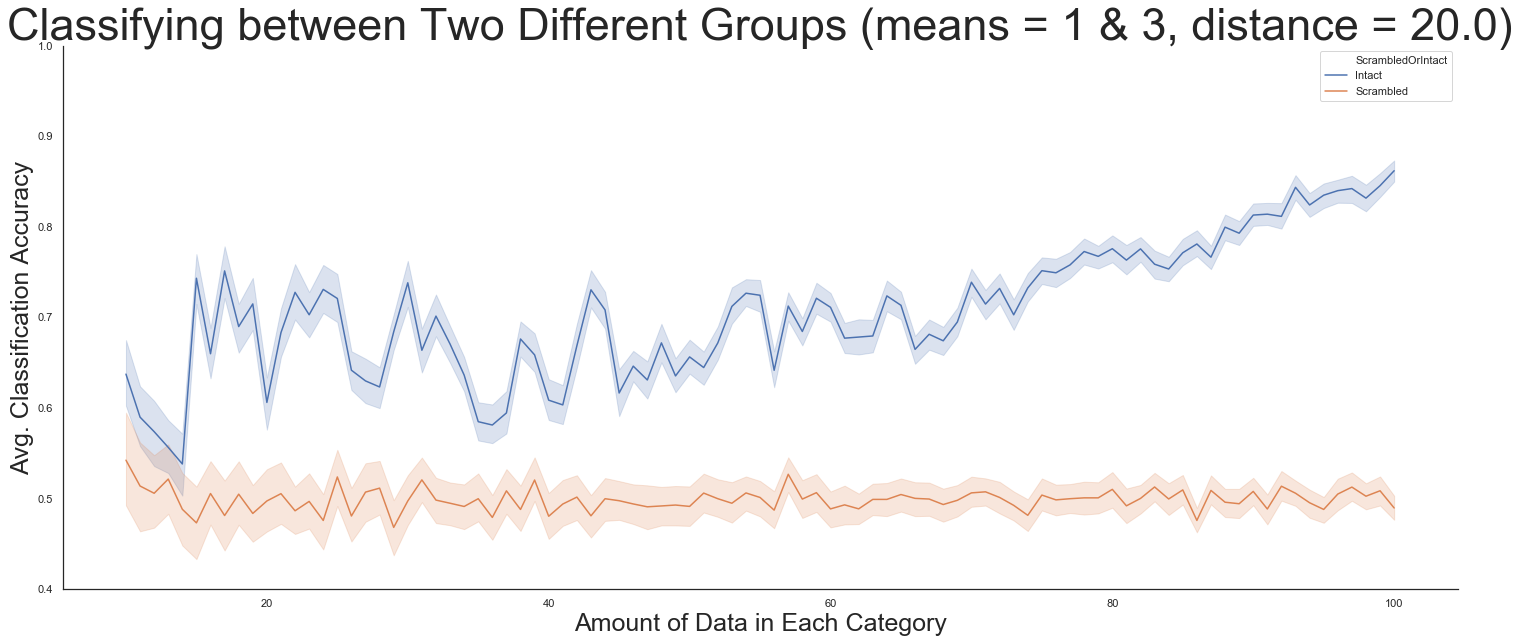

In [14]:
## plot average classification accuracy over sample sizes

# convert dictionary to dataframe (columns = sample sizes):
df = pd.DataFrame.from_dict(accuracyDict) # convert dict to dataframe: columns = sample sizes
df["iteration"] = df.index

# melt it to long format (each row = one accuracy measurement):
dfLong = pd.melt(df, id_vars='iteration')
dfLong.columns = ['iteration', 'sample size', 'classification accuracy']

# add scrambled-or-intact column:
dfLong['ScrambledOrIntact'] = ['Intact']*dfLong.shape[0]

# add scrambled data:
dfScram = pd.DataFrame.from_dict(accuracyDictScram)
dfScram["iteration"] = dfScram.index

# melt it into long format:
dfScramLong = pd.melt(dfScram, id_vars='iteration')
dfScramLong.columns = ['iteration', 'sample size', 'classification accuracy']
dfScramLong['ScrambledOrIntact'] = ['Scrambled']*dfScramLong.shape[0]


# add scrambled to intact data
dfs = [dfLong, dfScramLong]
dfIntactScram = pd.concat(dfs)


# plot it:
plt.figure(figsize=(25,10))
sns.set()
sns.set_style("white")
ax = sns.lineplot(x = 'sample size', y = 'classification accuracy', data = dfIntactScram, hue = "ScrambledOrIntact")

# make it pretty:
plt.ylim(.4, 1)
sns.despine()
ax.set_xlabel('Amount of Data in Each Category',fontsize=25);
ax.set_ylabel('Avg. Classification Accuracy',fontsize=25);
ax.set_title('Classifying between Two Different Groups (means = ' + str(popMeans_q1[0]) + ' & ' + str(popMeans_q1[1]) + ', distance = ' + str(dist) + ')', fontsize = 45);
